In [1]:
import os
import sys
import glob

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db       as DB
import invisible_cities.io      .pmap_io       as pmpio
import invisible_cities.io      .mchits_io     as mchio
import invisible_cities.core    .fit_functions as fitf
import invisible_cities.core    .exceptions    as excpt
import invisible_cities.reco    .xy_algorithms as XY

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import measurement_string

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 20

In [3]:
filename_pattern = "$IC_DATA/MC/Kr/*.h5"

In [10]:
filenames = glob.glob(os.path.expandvars(filename_pattern))[:2]

S1, S2, Si, MChits = {}, {}, {}, {}
for filename in filenames:
    s1, s2, si = pmpio.load_pmaps(filename)
    S1.update(s1)
    S2.update(s2)
    Si.update(si)

    mchits = mchio.load_mchits(filename)
    MChits.update(mchits)

In [11]:
DataSiPM = DB.DataSiPM()
xy_sipm  = np.stack([DataSiPM.X.values, DataSiPM.Y.values], axis=1)

In [12]:
def barycenter_Si(si, **corona_opts):
    IDs, Qs = zip(*si.sipm_total_energy_dict(0).items())
    return XY.corona(xy_sipm[list(IDs)], np.array(Qs), lm_radius=-1, **corona_opts)[0]

def barycenter_MC(hits):
    pos, Qs = zip(*[((hit.X, hit.Y), hit.E) for hit in hits])
    return XY.corona(np.array(pos), np.array(Qs), lm_radius=-1)[0]

def get(array, attr):
    return np.array([getattr(x, attr) for x in array])

def plot_si(si, **corona_opts):
    IDs, Qs = zip(*si.sipm_total_energy_dict(0).items())
    Xs , Ys = xy_sipm[list(IDs)].T
    s = plt.scatter(Xs, Ys, c=Qs, marker="s")
    b = barycenter_Si(si, **corona_opts)
    plt.scatter(b.X, b.Y, marker="x", c="r")
    return plt.colorbar(s)

def plot_mc(hits):
    Xs, Ys, Qs = zip(*[(hit.X, hit.Y, hit.E) for hit in hits])
    plt.scatter(Xs, Ys, c="k", marker="*")
    b = barycenter_MC(hits)
    return

def diff_str(var="x"):
    return f"${var}_b - {var}_t$"#.format(**locals())

def pull_str(var="x"):
    return fr"$\frac{{{var}_b - {var}_t}}{{\sqrt{{\sigma_b^2 + \sigma_t^2}}}}$"

In [13]:
pull_str("x"), diff_str("x")

('$\\frac{x_b - x_t}{\\sqrt{\\sigma_b^2 + \\sigma_t^2}}$', '$x_b - x_t$')

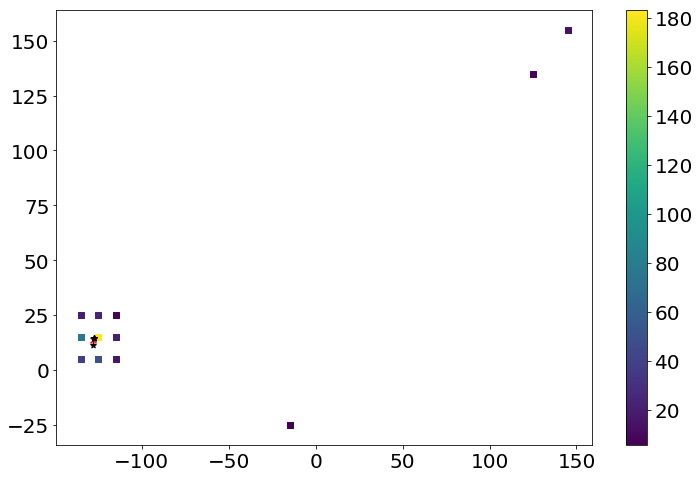

In [17]:
plot_si(next(iter(Si    .values())), Qthr=20)
plot_mc(next(iter(MChits.values())))

In [8]:
print("Si:", barycenter_Si(next(iter(Si.values()))))
print()
print("MC:", barycenter_MC(next(iter(MChits.values()))))

Si: < nsipm = 12 Q = 464.4228138923645
                    xy = xy(x=-112.82010881080393, y=19.827140816431996) 3dHit = <[-112.82010881080393, 19.827140816431996, -9.425] 464.4228138923645>  >

MC: < nsipm = 5 Q = 0.03612640080973506
                    xy = xy(x=-127.375244140625, y=13.87238597869873) 3dHit = <[-127.375244140625, 13.87238597869873, -9.425] 0.03612640080973506>  >


In [9]:
datab = []
datat = []

Qthr = 30
for evt, hits in MChits.items():
    try:
        datab.append(barycenter_Si(Si[evt], Qthr=Qthr))
        datat.append(barycenter_MC(hits   ))
    except (KeyError, excpt.SipmEmptyListAboveQthr):
        pass

In [10]:
Xb = get(datab, "X")
Yb = get(datab, "Y")
Xt = get(datat, "X")
Yt = get(datat, "Y")

Nb = get(datab, "nsipm")
Nt = get(datat, "nsipm")

sXb = get(datab, "Xrms") / Nb**0.5
sYb = get(datab, "Yrms") / Nb**0.5
sXt = get(datat, "Xrms") / Nt**0.5
sYt = get(datat, "Yrms") / Nt**0.5

Rb = (Xb**2 + Yb**2)**0.5
Rt = (Xt**2 + Yt**2)**0.5

In [11]:
diff_x = Xb - Xt
pull_x = diff_x  / (sXb**2 + sXt**2)**0.5
diff_y = Yb - Yt
pull_y = diff_y  / (sYb**2 + sYt**2)**0.5

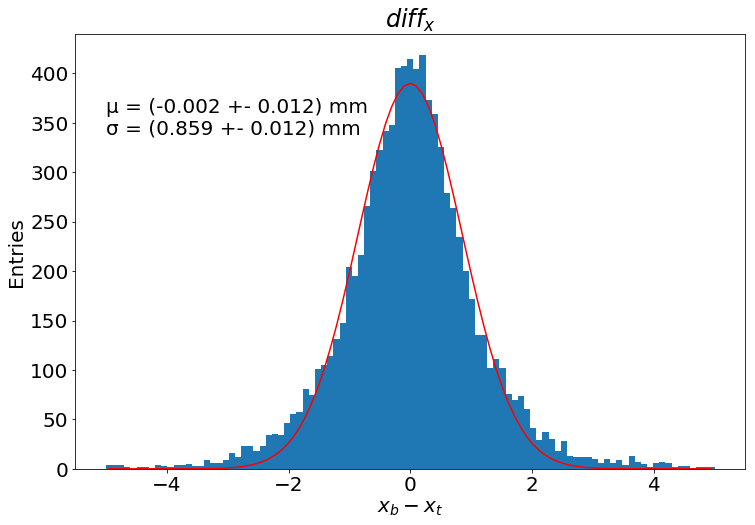

In [31]:
y, x, _ = hist(diff_x, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(-5, plt.ylim()[1]/1.3, "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                                                  measurement_string(f.values[2], f.errors[2])))
labels(diff_str("x"), "Entries", "$diff_x$")

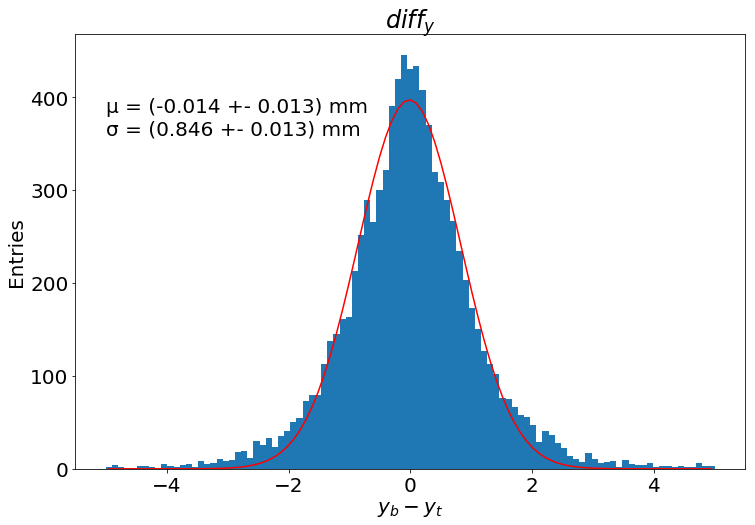

In [13]:
y, x, _ = hist(diff_y, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(-5, plt.ylim()[1]/1.3, "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                                                  measurement_string(f.values[2], f.errors[2])))
labels(diff_str("y"), "Entries", "$diff_y$")

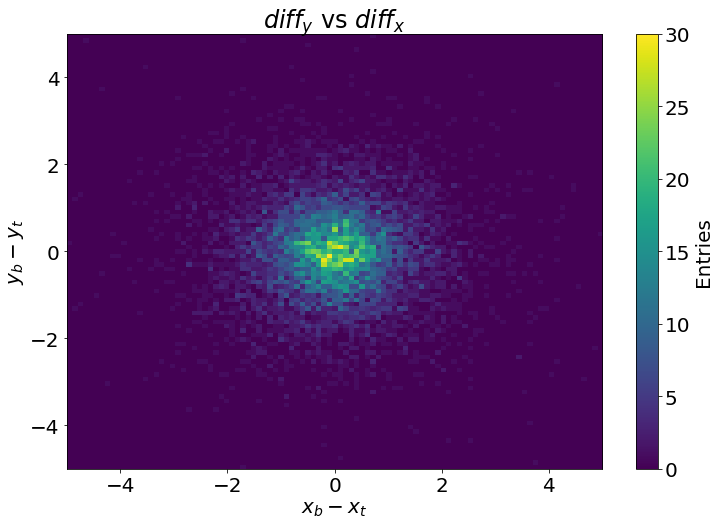

In [32]:
hist2d(diff_x, diff_y, (np.linspace(-5, 5, 100),
                        np.linspace(-5, 5, 100)))
plt.colorbar().set_label("Entries")
labels(diff_str("x"), diff_str("y"), "$diff_y$ vs $diff_x$")

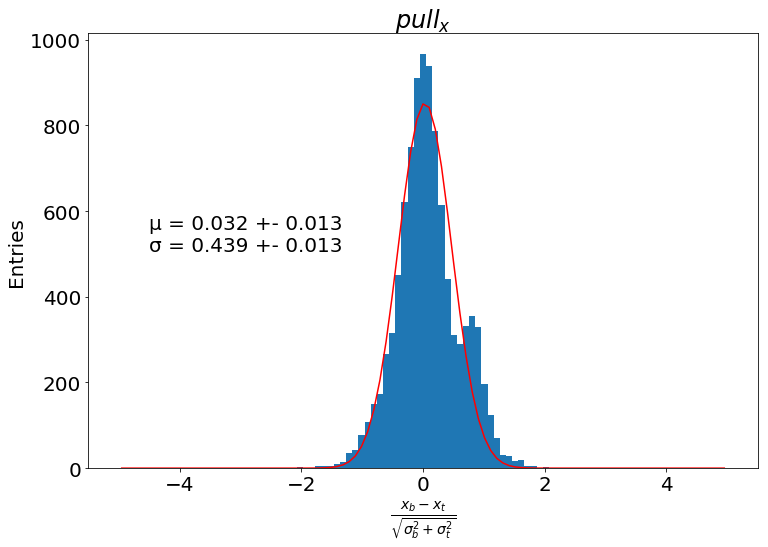

In [33]:
y, x, _ = hist(pull_x, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(-4.5, plt.ylim()[1]/2, "µ = {}\nσ = {}".format(measurement_string(f.values[1], f.errors[1]),
                                                        measurement_string(f.values[2], f.errors[2])))
labels(pull_str("x"), "Entries", "$pull_x$")

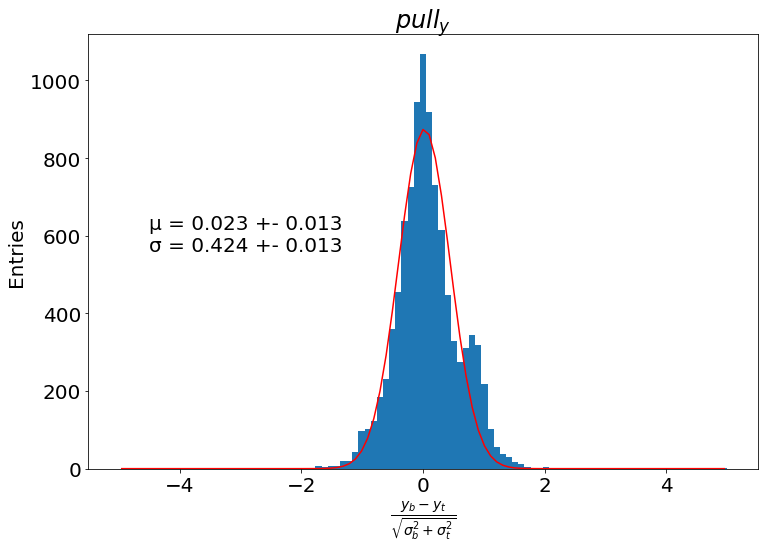

In [34]:
y, x, _ = hist(pull_y, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(-4.5, plt.ylim()[1]/2, "µ = {}\nσ = {}".format(measurement_string(f.values[1], f.errors[1]),
                                                        measurement_string(f.values[2], f.errors[2])))
labels(pull_str("y"), "Entries", "$pull_y$")

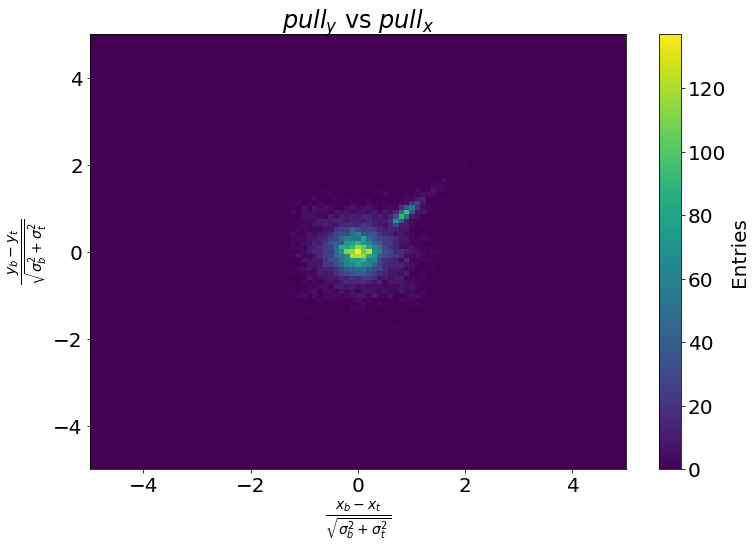

In [35]:
hist2d(pull_x, pull_y, (np.linspace(-5, 5, 100),
                        np.linspace(-5, 5, 100)))
plt.colorbar().set_label("Entries")
labels(pull_str("x"), pull_str("y"), "$pull_y$ vs $pull_x$")

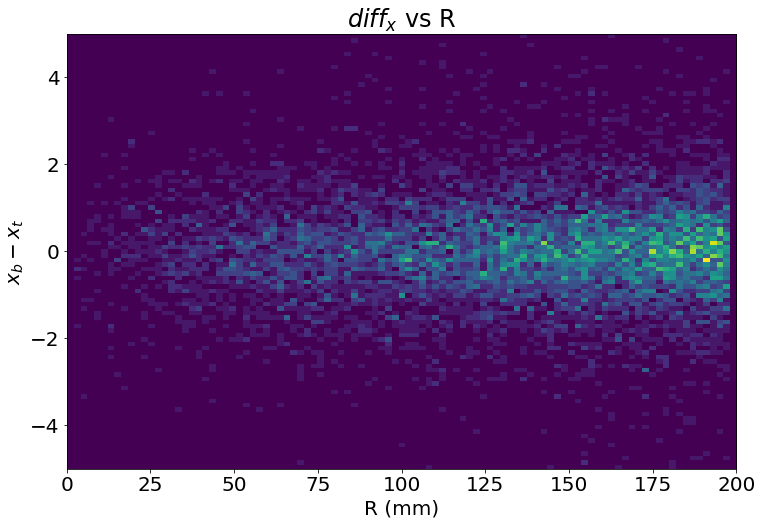

In [16]:
z, x, y, _ = hist2d(Rt, diff_x, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", diff_str("x"), "$diff_x$ vs R")

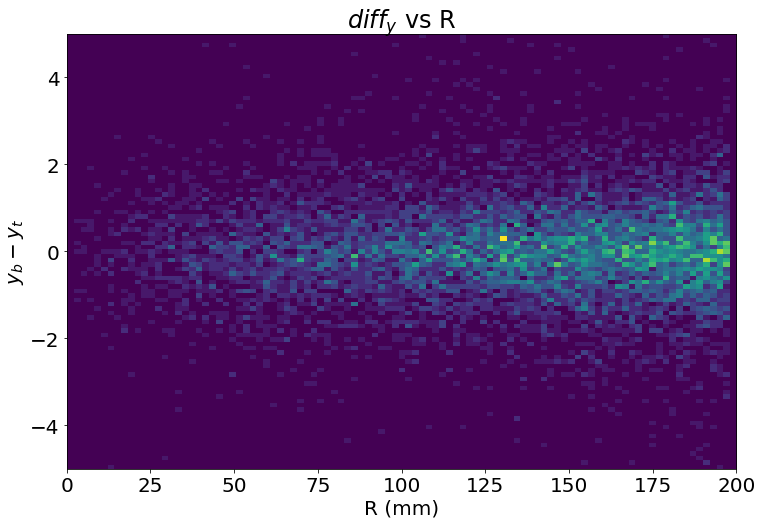

In [17]:
z, x, y, _ = hist2d(Rt, diff_y, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", diff_str("y"), "$diff_y$ vs R")

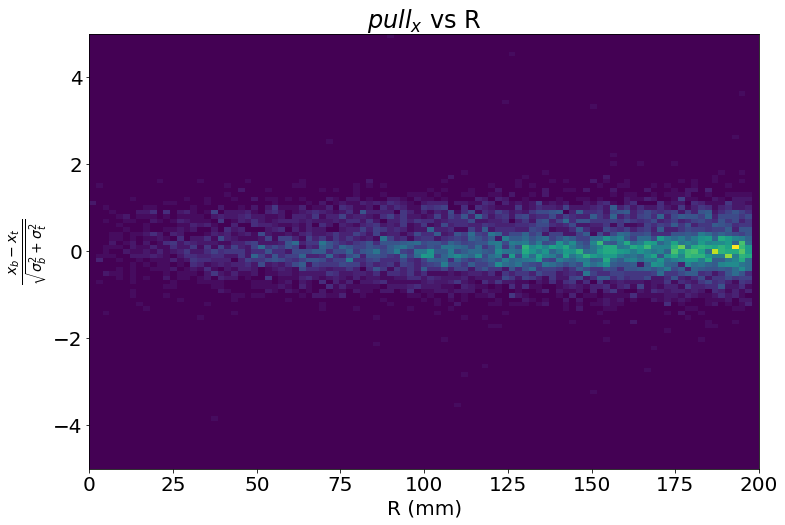

In [18]:
z, x, y, _ = hist2d(Rt, pull_x, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", pull_str("x"), "$pull_x$ vs R")

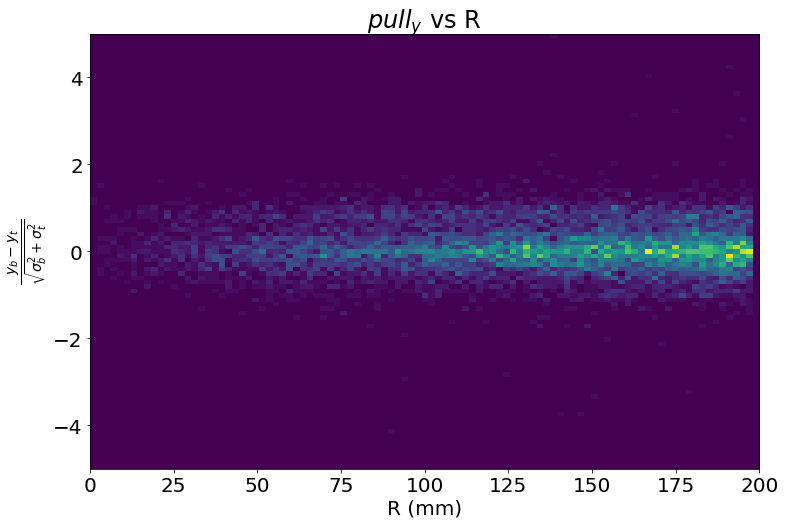

In [19]:
z, x, y, _ = hist2d(Rt, pull_y, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", pull_str("y"), "$pull_y$ vs R")

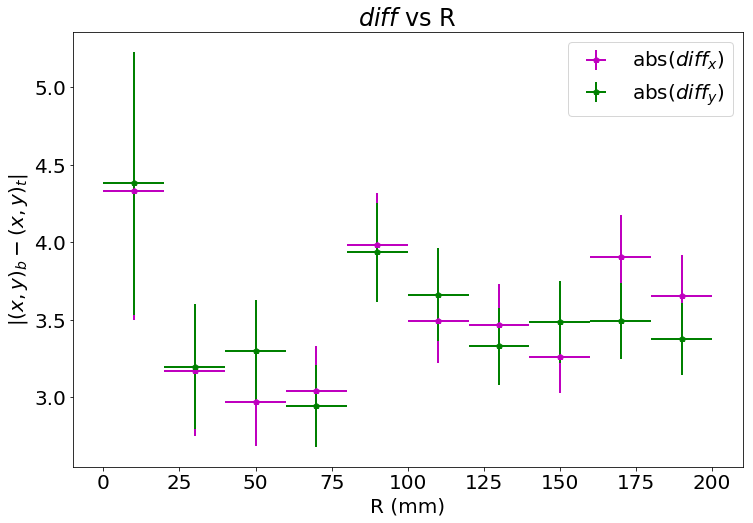

In [39]:
r, x, u_x = fitf.profileX(Rt, np.abs(diff_x), 10, xrange=(0,200))
_, y, u_y = fitf.profileX(Rt, np.abs(diff_y), 10, xrange=(0,200))

plt.errorbar(r, x, u_x, np.diff(r)[0] * 0.5, "mp", label="abs($diff_x$)", lw=2)
plt.errorbar(r, y, u_y, np.diff(r)[0] * 0.5, "gp", label="abs($diff_y$)", lw=2)
plt.legend()
labels("R (mm)", "|{}|".format(diff_str("(x,y)")), "$diff$ vs R")

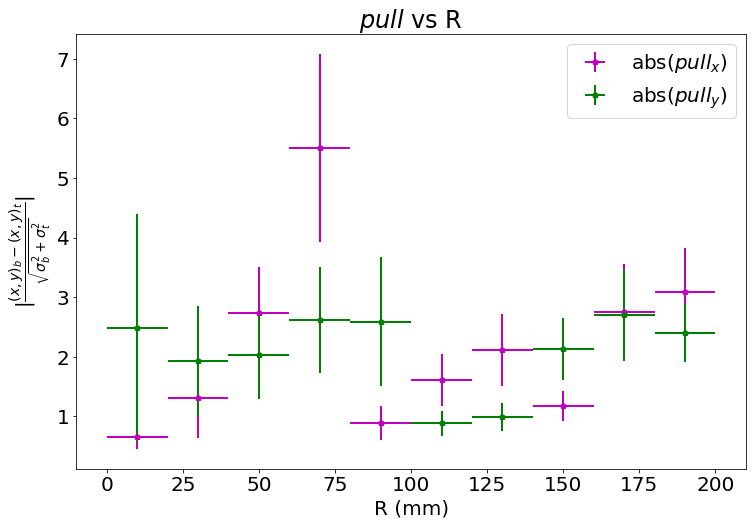

In [40]:
r, x, u_x = fitf.profileX(Rt, np.abs(pull_x), 10, xrange=(0,200))
_, y, u_y = fitf.profileX(Rt, np.abs(pull_y), 10, xrange=(0,200))

plt.errorbar(r, x, u_x, np.diff(r)[0] * 0.5, "mp", label="abs($pull_x$)", lw=2)
plt.errorbar(r, y, u_y, np.diff(r)[0] * 0.5, "gp", label="abs($pull_y$)", lw=2)
plt.legend()
labels("R (mm)", "|{}|".format(pull_str("(x,y)")), "$pull$ vs R")